In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

### Datasets Description
The dataset consist of small pathology images with binary labels (0 and 1). A positive label (1) are images of patients with cancer and at the center of these images a there is  at least one pixel of tumor tissue in the region of 32x32px. The images with negative label do not contain this tumor tissue.
Our task here is to classify images by detecting this tumor tissue to either positive or negative class

### Image Visulaisation
Ti understand the images better I will first display 5 images from each class to check if there is any visual difference between images of both labels. 

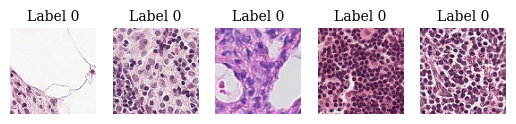

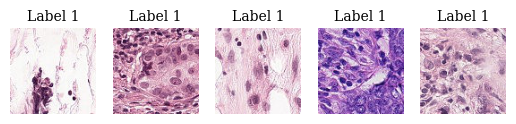

In [2]:
n_images=5
path=os.getcwd()+"/histopathologic-cancer-detection/"
df =pd.read_csv(path+"train_labels.csv")
img_classes=[]
img_classes.append(df[df["label"] == 0])
img_classes.append(df[df["label"] == 1])

font1 = {'family':'serif','color':'black','size':10}
for label in [0,1]:
    for i in range(n_images):
        file=path+"train/"+img_classes[label]["id"].iloc[i]+'.tif'
        image = plt.imread(file)
        plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Label "+str(label),fontdict = font1)
    plt.show() 

As we can see from the images above that it is not possible for a person without domain knowledge to detect the difference between both classes by looking at them.

## EDA
The data is divided in both test and train dataset. There are total 220,025 images in training data and 57458 images in test data. The labels for training data are provided and the target is to predict the presence/absence of tumor in test data images.

## EDA Issues
Since the dataset consist of images we have limited options of performing data analysis here. I will apply the following techniques for the data analysis
1. Analysis of distribution of labels in test data 
2. Ana


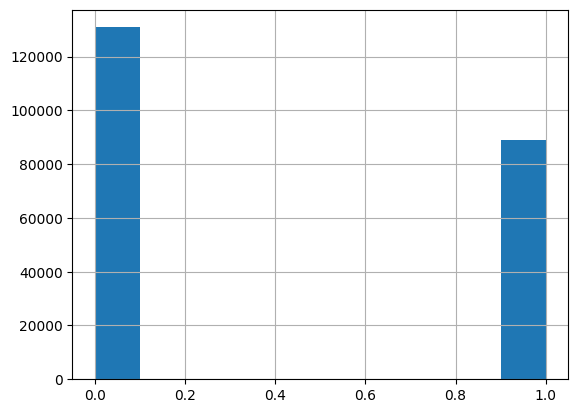

In [3]:
hist = df['label'].hist()

##  Distribution of Labels
I create a histogram to examine the distribution of label values in the training data. The above diagram reveals that there are nearly 130,000 images associated with class 0 and around 90,000 images associated with class 1. This indicates that while the data is not perfectly balanced, the amount of data for the minority class is sufficiently substantial for the classification task.

In [3]:
#!pip install seaborn
import cv2
import seaborn as sns
avg_data = []
outliers = []
for i in range(0,len(df)):
    img_path=path+"train/"+df["id"].iloc[i]+'.tif'
    img= plt.imread(img_path)
    color_range = np.mean([np.mean(img[:,:,2]), np.mean(img[:,:,1]), np.mean(img[:,:,0])])
    if ((color_range <= 45) or (color_range >= 245)) : 
        outliers.append(i)   
print(outliers)
#x_train=np.delete(x_train, outliers , axis = 0)
#y_train=np.delete(y_train, outliers , axis = 0)


[123, 285, 436, 1273, 1562, 2992, 3120, 3267, 3310, 3666, 4536, 5033, 5321, 5549, 6178, 6228, 6401, 6646, 6808, 6824, 7106, 7432, 7577, 7580, 7765, 7790, 8927, 9169, 9246, 9372, 9466, 10113, 10706, 11031, 11839, 11979, 12201, 12438, 12603, 12703, 12771, 12905, 13085, 13148, 13167, 13357, 13682, 13738, 14587, 14923, 15029, 15180, 15217, 15559, 16246, 16363, 16906, 17010, 17605, 17649, 18494, 18971, 19569, 19673, 19854, 20266, 20274, 20283, 20560, 20686, 20731, 20967, 20981, 21165, 21965, 22000, 22240, 22241, 22601, 23518, 24044, 24519, 24538, 25491, 25504, 25628, 25667, 25931, 25957, 26021, 26345, 26688, 27286, 27762, 27909, 28340, 28629, 28852, 29563, 30073, 30268, 30577, 31135, 31176, 31222, 31239, 31614, 31616, 32627, 32681, 32829, 33108, 33358, 34098, 34177, 34400, 34655, 34777, 35060, 35605, 35657, 35840, 35853, 35930, 36081, 36158, 36297, 36405, 36574, 36737, 37153, 37206, 38056, 38477, 38620, 38679, 39732, 39900, 39982, 40020, 40332, 40676, 40827, 41142, 41187, 41277, 42990, 4325

2024-02-03 15:34:38.549935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 15:34:38.549995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 15:34:38.606638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 15:34:38.722059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 15:34:39.979676: W tensorflow/compiler/tf2

Found 220025 validated image filenames belonging to 2 classes.


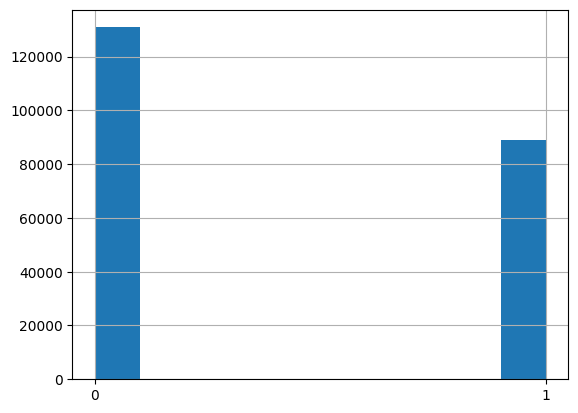

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications import ResNet50

train_df = df
train_df['id'] = train_df['id'] + '.tif'
train_df['label'] = train_df['label'].astype(str)
train_df.head()
#datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
datagen = ImageDataGenerator()

train_data = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id', 
    y_col = 'label',
    directory = "histopathologic-cancer-detection/train",
    subset = 'training',
    class_mode = 'binary',
    batch_size = 15,
    target_size = (96,96))

hist = train_df['label'].hist()

In [5]:
def plot_accuracy_epoch(h):
    plt.plot(h.history["accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title("Model Evaluation")
    plt.show()
def plot_loss_epoch(h):
    plt.plot(h.history["loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Model Evaluation")
    plt.show()

In [6]:
n_epochs=10


Epoch 1/10
14669/14669 [==============================] - 165s 11ms/step - loss: 1.7203 - accuracy: 0.5936
Epoch 2/10
14669/14669 [==============================] - 160s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 3/10
14669/14669 [==============================] - 161s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 4/10
14669/14669 [==============================] - 166s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 5/10
14669/14669 [==============================] - 160s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 6/10
14669/14669 [==============================] - 159s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 7/10
14669/14669 [==============================] - 161s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 8/10
14669/14669 [==============================] - 159s 11ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 9/10
14669/14669 [==============================] - 160s 11ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 10/10
14669/14669 [============

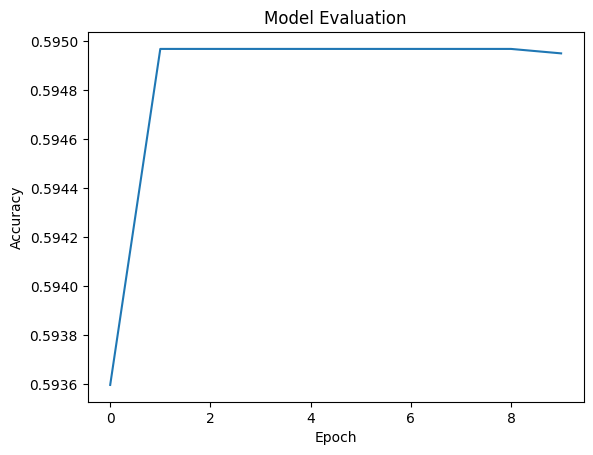

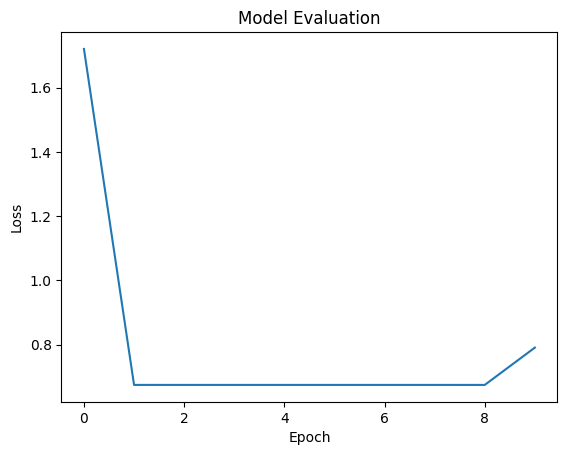

In [9]:
#CNN
model = Sequential()
model.add(Conv2D(16,kernel_size=3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

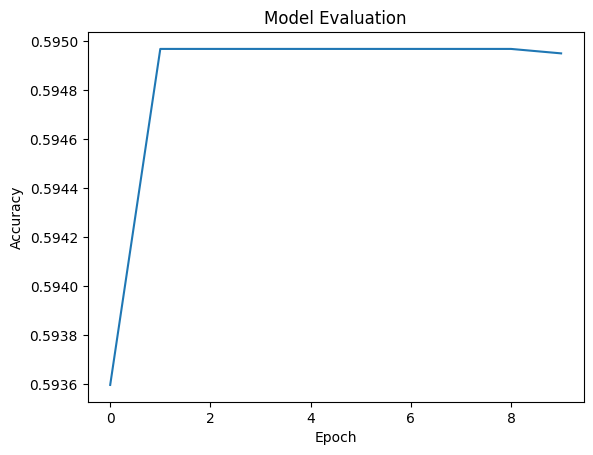

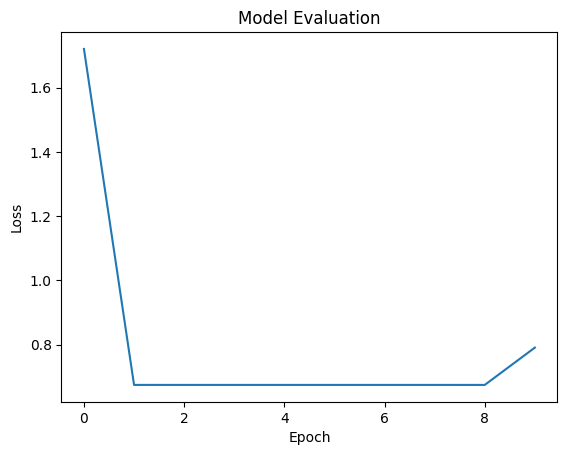

In [10]:
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

Epoch 1/10
14669/14669 [==============================] - 425s 29ms/step - loss: 2.0372 - accuracy: 0.8057
Epoch 2/10
14669/14669 [==============================] - 429s 29ms/step - loss: 2.0257 - accuracy: 0.8121
Epoch 3/10
14669/14669 [==============================] - 429s 29ms/step - loss: 2.0342 - accuracy: 0.8129
Epoch 4/10
14669/14669 [==============================] - 431s 29ms/step - loss: 2.0584 - accuracy: 0.8132
Epoch 5/10
14669/14669 [==============================] - 427s 29ms/step - loss: 2.0667 - accuracy: 0.8135
Epoch 6/10
14669/14669 [==============================] - 428s 29ms/step - loss: 2.0494 - accuracy: 0.8144
Epoch 7/10
14669/14669 [==============================] - 428s 29ms/step - loss: 2.0473 - accuracy: 0.8151
Epoch 8/10
14669/14669 [==============================] - 429s 29ms/step - loss: 2.0544 - accuracy: 0.8153
Epoch 9/10
14669/14669 [==============================] - 432s 29ms/step - loss: 2.0674 - accuracy: 0.8146
Epoch 10/10
14669/14669 [============

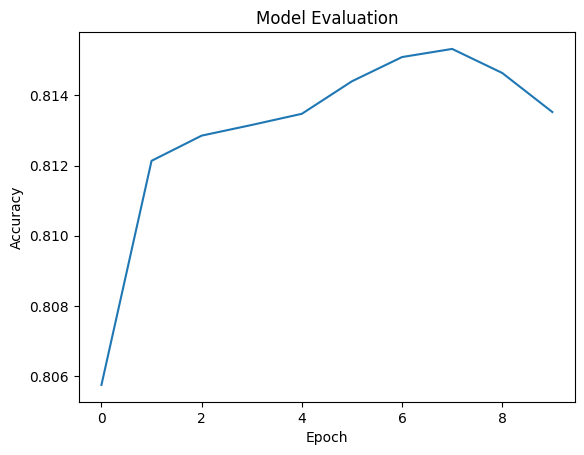

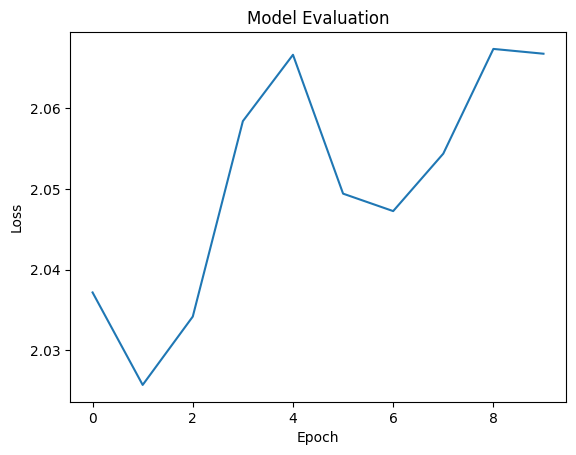

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16=VGG16(include_top=False, input_shape=(96,96, 3))
vgg16.trainable = False
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

94765736/94765736 [==============================] - 36s 0us/step


Epoch 1/10
14669/14669 [==============================] - 438s 30ms/step - loss: 0.7542 - accuracy: 0.8315
Epoch 2/10
14669/14669 [==============================] - 433s 29ms/step - loss: 0.7371 - accuracy: 0.8475
Epoch 3/10
14669/14669 [==============================] - 434s 30ms/step - loss: 0.7328 - accuracy: 0.8520
Epoch 4/10
14669/14669 [==============================] - 435s 30ms/step - loss: 0.7295 - accuracy: 0.8549
Epoch 5/10
14669/14669 [==============================] - 433s 29ms/step - loss: 0.7215 - accuracy: 0.8574
Epoch 6/10
14669/14669 [==============================] - 434s 30ms/step - loss: 0.7204 - accuracy: 0.8589
Epoch 7/10
14669/14669 [==============================] - 434s 30ms/step - loss: 0.7227 - accuracy: 0.8598
Epoch 8/10
14669/14669 [==============================] - 432s 29ms/step - loss: 0.7281 - accuracy: 0.8601
Epoch 9/10
14669/14669 [==============================] - 432s 29ms/step - loss: 0.7328 - accuracy: 0.8607
Epoch 10/10
14669/14669 [============

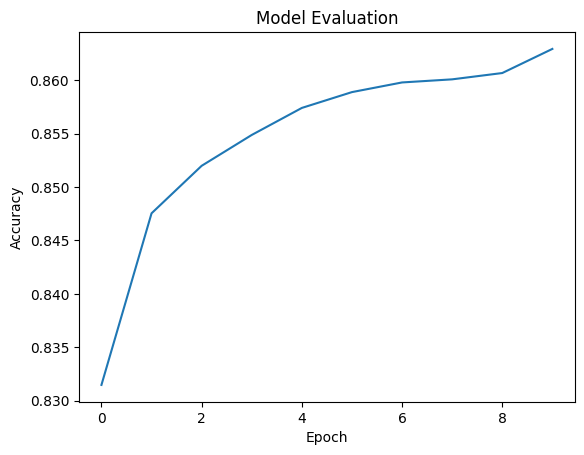

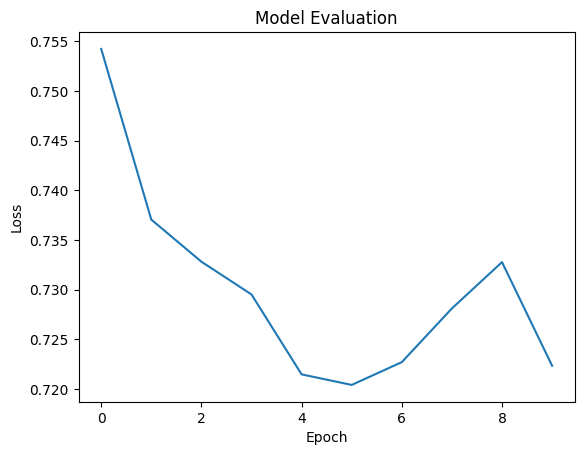

In [13]:
res50 = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96, 3))
res50.trainable = False
model = Sequential()
model.add(res50 )
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

Epoch 1/10
14669/14669 [==============================] - 1321s 90ms/step - loss: 0.5727 - accuracy: 0.7389
Epoch 2/10
14669/14669 [==============================] - 1305s 89ms/step - loss: 0.6816 - accuracy: 0.5950
Epoch 3/10
14669/14669 [==============================] - 1305s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 4/10
14669/14669 [==============================] - 1303s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 5/10
14669/14669 [==============================] - 1303s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 6/10
14669/14669 [==============================] - 1306s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 7/10
14669/14669 [==============================] - 1309s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 8/10
14669/14669 [==============================] - 1304s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 9/10
14669/14669 [==============================] - 1302s 89ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 10/10
14669/14669 [===

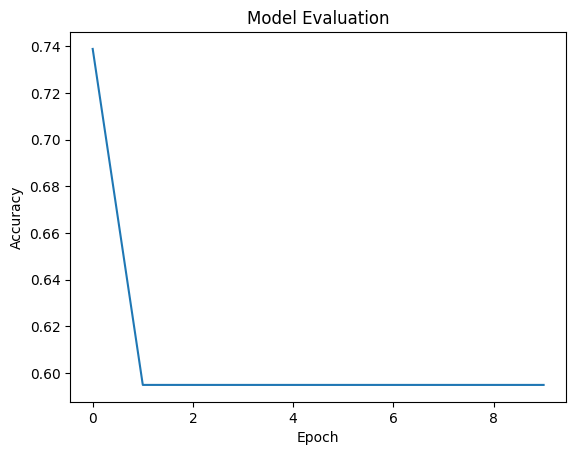

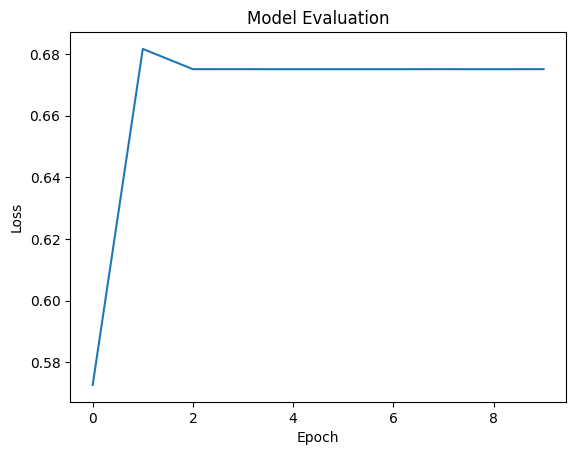

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16=VGG16(include_top=False, input_shape=(96,96, 3))
vgg16.trainable = True
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

2024-02-03 15:34:55.058589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:34:55.362900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:34:55.362983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:34:55.365899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:34:55.366004: I external/local_xla/xla/stream_executor

Epoch 1/10


2024-02-03 15:35:21.572146: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-03 15:35:21.856786: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-03 15:35:22.553634: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-03 15:35:24.582701: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f08ec001ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 15:35:24.582737: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-02-03 15:35:24.599069: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706956524.673336     583 device_compil

14669/14669 [==============================] - 1525s 101ms/step - loss: 0.5487 - accuracy: 0.7605
Epoch 2/10
14669/14669 [==============================] - 1463s 100ms/step - loss: 0.3668 - accuracy: 0.8449
Epoch 3/10
14669/14669 [==============================] - 1455s 99ms/step - loss: 0.3335 - accuracy: 0.8616
Epoch 4/10
14669/14669 [==============================] - 1456s 99ms/step - loss: 0.3075 - accuracy: 0.8777
Epoch 5/10
14669/14669 [==============================] - 1468s 100ms/step - loss: 0.2870 - accuracy: 0.8855
Epoch 6/10
14669/14669 [==============================] - 1805s 123ms/step - loss: 0.2697 - accuracy: 0.8936
Epoch 7/10
14669/14669 [==============================] - 1438s 98ms/step - loss: 0.2470 - accuracy: 0.9039
Epoch 8/10
14669/14669 [==============================] - 1446s 99ms/step - loss: 0.2303 - accuracy: 0.9103
Epoch 9/10
14669/14669 [==============================] - 1433s 98ms/step - loss: 0.2210 - accuracy: 0.9145
Epoch 10/10
14669/14669 [==========

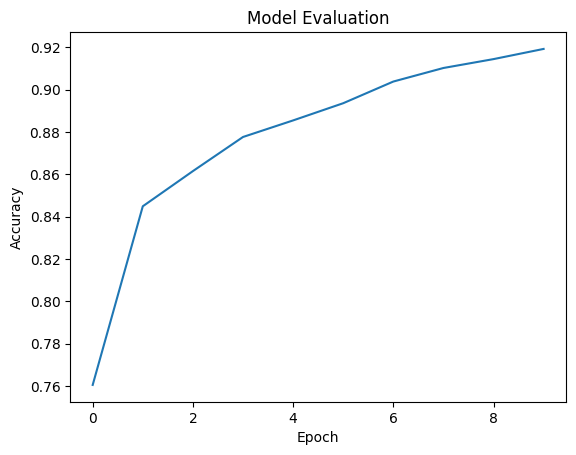

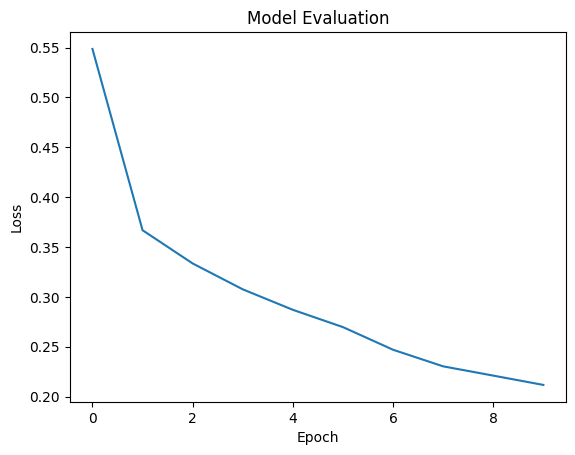

In [7]:
res50 = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96, 3))
res50.trainable = True
model = Sequential()
model.add(res50 )
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  batch_size=128,verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)


Epoch 1/10


2024-02-03 05:13:36.926096: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-03 05:13:36.926168: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-03 05:13:36.961726: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-03 05:13:36.961786: W external/local_tsl/tsl/framework/bfc_

14669/14669 [==============================] - 1511s 101ms/step - loss: 0.4540 - accuracy: 0.8171
Epoch 2/10
14669/14669 [==============================] - 1492s 102ms/step - loss: 0.3307 - accuracy: 0.8681
Epoch 3/10
14669/14669 [==============================] - 1484s 101ms/step - loss: 0.2758 - accuracy: 0.8934
Epoch 4/10
14669/14669 [==============================] - 1490s 102ms/step - loss: 0.2514 - accuracy: 0.9035
Epoch 5/10
14669/14669 [==============================] - 1489s 101ms/step - loss: 0.2235 - accuracy: 0.9148
Epoch 6/10
14669/14669 [==============================] - 1474s 100ms/step - loss: 0.2093 - accuracy: 0.9212
Epoch 7/10
14669/14669 [==============================] - 1461s 100ms/step - loss: 0.1980 - accuracy: 0.9259
Epoch 8/10
14669/14669 [==============================] - 1461s 100ms/step - loss: 0.1972 - accuracy: 0.9260
Epoch 9/10
14669/14669 [==============================] - 1476s 101ms/step - loss: 0.1780 - accuracy: 0.9342
Epoch 10/10
14669/14669 [=====

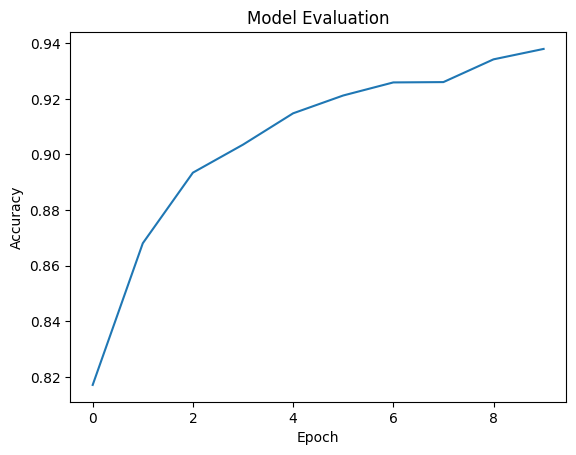

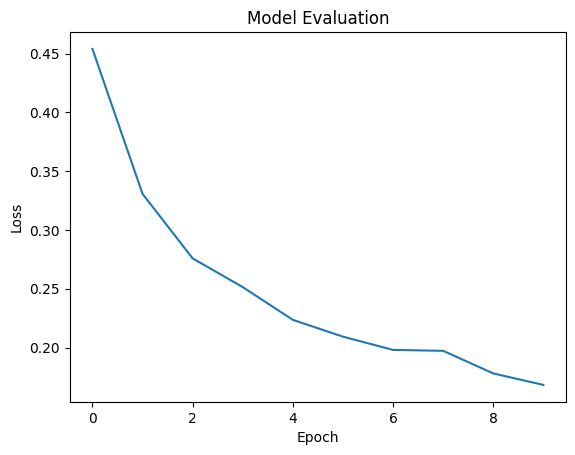

In [15]:
res50 = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96, 3))
res50.trainable = True
model = Sequential()
model.add(res50 )
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, epochs = n_epochs,  verbose=1)
plot_accuracy_epoch(hist)
plot_loss_epoch(hist)

In [11]:
import cv2
test_images = []
p1=path+"test/"
for fname in os.listdir(p1):
    img = cv2.imread(os.path.join(p1,fname))
    if img is not None:
        test_images.append(img)
test_images=np.array(test_images)

In [13]:
predictions=model.predict(test_images)


2024-02-03 19:56:31.333758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1588598784 exceeds 10% of free system memory.
2024-02-03 19:56:32.542989: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1588598784 exceeds 10% of free system memory.


1796/1796 [==============================] - 66s 35ms/step


In [24]:
pred=predictions
pred[pred>=0.5]=1
pred[pred<0.5]=0
pred=pred.astype(int)

In [25]:
outFile = 'predictions.csv'
image_ids=[]
for fname in os.listdir(p1):
    image_ids.append(fname[:-4])
data = {'id': image_ids,
        'prediction': pred[:,0].tolist()}
 
# Create DataFrame
df = pd.DataFrame(data)
df.head()

,id,prediction
0,bd9a250eeda65b42864d40b747e6c6e9074cff39,1
1,7008a57d4ba1e46f547c3b003ba513793af29e42,0
2,34e187aeb008a8ad076366d9aaae5d0722e6d11c,0
3,112d16c637013e4766c2613e575abc023f9259bf,0
4,f1f2303e2000787da2a926e16359fcbaeb0af5d5,0


In [27]:
df.to_csv("predictions.csv",index=False)

In [28]:
model.save('restnet_tr') 

INFO:tensorflow:Assets written to: restnet_tr/assets


INFO:tensorflow:Assets written to: restnet_tr/assets


In [30]:
model.save_weights('weights.h5')